# HarvestStat Data Analysis - Madagascar

## Issue 1: Year-off issue

In [5]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Madagascar',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df[
    (df['product'] == 'Maize (Corn)') &
    (df['indicator'] == 'Quantity Produced')
].pivot_table(index='period_date', columns='fnid', values='value').sum(axis=1).tail(10)

period_date
2011-03-31    446729.000000
2013-03-31    447947.961868
2014-03-31    379246.096558
2015-03-31    364128.272258
2016-03-31    329366.556790
2017-03-31    316331.438744
2018-03-31    281487.468508
2019-03-31    215000.547016
2020-03-31    219220.476429
2021-03-31    224883.087739
dtype: float64

## Issue 2: Missing records

In [15]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Madagascar',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df[
    (df['product'] == 'Rice (Paddy)')
].pivot_table(index='period_date', columns='indicator', values='value', aggfunc='count')

indicator,Area Harvested,Area Planted,Quantity Produced,Yield
period_date,,,,
1991-03-31,NaN,101.0,101.0,101.0
1992-03-31,NaN,101.0,101.0,101.0
1993-03-31,NaN,101.0,101.0,101.0
1994-03-31,NaN,100.0,100.0,100.0
1995-03-31,NaN,100.0,100.0,100.0
1996-03-31,NaN,100.0,100.0,100.0
1997-03-31,NaN,100.0,100.0,100.0
1998-03-31,NaN,100.0,100.0,100.0
1999-03-31,NaN,100.0,100.0,100.0


## Validation with FAOSTAT and CHIRPS Precipitation

Annual-Rice Correlation:
          FAO        HS      PRCP
FAO   1.00000  0.982030  0.097240
HS    0.98203  1.000000  0.196852
PRCP  0.09724  0.196852  1.000000


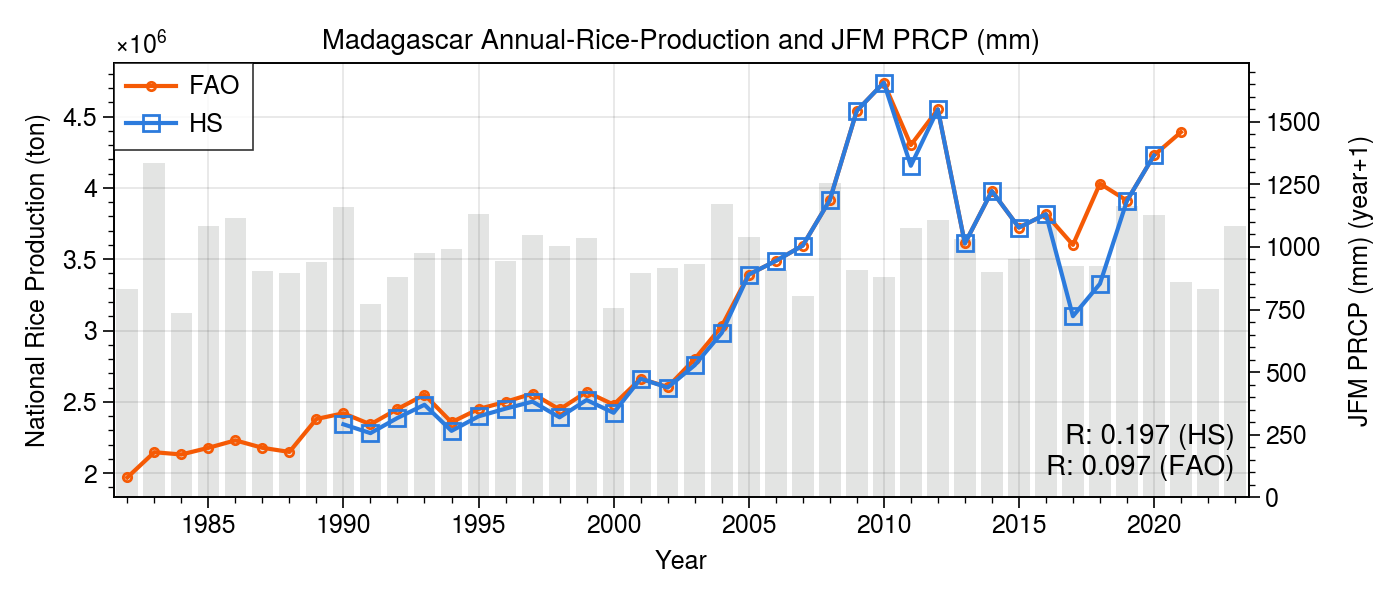

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import proplot as pplot
# Load Crop Data ------------------------------------- #
# country_name, season_name, product_name_fdw, product_name_fao,  = 'Madagascar', 'Annual', 'Maize', 'Maize (corn)'
country_name, season_name, product_name_fdw, product_name_fao,  = 'Madagascar', 'Annual', 'Rice', 'Rice'
shape_code, prcp_start_month, prcp_season_name, prcp_year_offset = 'MG2009A0', 1, 'JFM PRCP (mm)', +1
# HarvestStat
df = pd.read_csv('../public/hvstat_data.csv', index_col=0)
df = df[
    (df['country'] == country_name) &
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name_fdw])) &
    (df['indicator'] == 'production')
].copy()
df['year'] = df['harvest_year']
data_hs = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').squeeze()
# FAO-STAT
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == country_name) &
    (df['cpc2_name'] == product_name_fao) &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# Merge
data = pd.concat([data_fao,data_hs], axis=1, keys=['FAO','HS']).sort_index()
data = data.reindex(np.array(range(1982,2024)))
# ---------------------------------------------------- #
# Load precipitation --------------------------------- #
fn = '../data/prcp_chirps-v2.hdf'
prcp_nat = pd.read_hdf(fn)[shape_code].resample('1M').agg('sum')
prcp_nat.index = prcp_nat.index.map(lambda x: x.replace(day=1))
prcp_nat.name = 'PRCP'
prcp_nat.index = prcp_nat.index + pd.DateOffset(years=prcp_year_offset)
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == prcp_start_month]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = prcp_season_name
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'{season_name}-{product_name_fdw} Correlation:\n{corr_value}')
# ---------------------------------------------------- #
# Comparison with Precipitation ---------------------- #
fig, ax1 = plt.subplots(figsize=(7,3))
fig.set_facecolor('white')
data.plot(ax=ax1, grid=True, markerfacecolor='None',color=['#F55A05','#2C7BDD'])
marker = ['.','s']
for i, line in enumerate(ax1.get_lines()):
    line.set_marker(marker[i])
# years = data.index
# ax1.set_xticks(years)
# ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.set_xlim([data.index[0]-0.5, data.index[-1]+0.5])
ax1.set_xlabel('Year')
ax1.set_ylabel('National %s Production (ton)' % product_name_fdw)
ax1.patch.set_facecolor('white')
# Precipitation
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label + ' (year+%d)'%prcp_year_offset, labelpad=10)
ax2.grid(False)
ax1.set_zorder(1)  
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(loc='upper left')
ax1.annotate(
    'R: %.3f (HS)\nR: %.3f (FAO)' % (corr_value.loc['HS','PRCP'], corr_value.loc['FAO','PRCP']), 
    xy=(1, 0.2), xycoords='axes fraction', fontsize=10,
    xytext=(-5, -5), textcoords='offset points',
    ha='right', va='top'
)
title = f'{country_name} {season_name}-{product_name_fdw}-Production and {prcp_label}'
ax1.set_title(title)
fig.tight_layout()
plt.show()
# ---------------------------------------------------- #